### IRIS 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋: iris.csv 2개 (1개 피쳐, 1개 타겟) feature 사용
- Linear regression
- 너비 예측
- 구현_프레임워크: Pytorch
- Train, test, Validation Dataset 생성

In [1]:
import torch					# 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn			# 인공신경망 관련 모듈
import torch.nn.functional as F 	# 손실, 거래 등 함수 관련 모듈
import torch.optim as optimizer # 최적화 기법 관련 모듈

from torchinfo import summary	# 모델 정보 관련 모듈		+) 추가 설치
from torchmetrics.regression import R2Score		# 성능지표 관련 모듈 +) 추가 설치
import pandas as pd				# 데이터 파일 분석 관련 모듈

from sklearn.model_selection import train_test_split		# trainDS, testDS 분할 관련 모듈듈

In [2]:
# 모델 가중치, 절편 초기값 고정
torch.manual_seed(1)

# 저장 및 실행 위치 고정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{DEVICE}')

cpu


In [3]:
DATA_FILE = r"C:\Users\KDP-43\Desktop\머신러닝_1\data\boston.csv"

bostonDF = pd.read_csv(DATA_FILE)			
bostonDF.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.9,9.14,21.6


[2] 모델 준비
- 학습방법: 지도학습 >> 회귀
- 알고리즘: 선형관계 >> 선형모델 >> nn.Linear

* +) LeakyReLU => 기울기 소실 방지 (기울기=0이면 피쳐에 대한 가중치=0이 되어 모델에 피쳐 학습 불가!)

In [4]:
## 모델 설계
# 입쳑층에 입력값/피쳐	: petal.length 3개
# 출력층의 출력값/피쳐	: petal.width  1개


# 입력층: 입력 피쳐:3개,	출력 입력층에 존재하는 퍼셉트론 개수 10		=> AF(활성함수): ReLU
#				_________________|
#			   |	ReLU
#			   V
# 은닉충: 입력 10, 			출력 은닉층에 존재하는 퍼셉트론 개수 5	   => AF(활성함수): ReLU
#			  _________________|
#			 |	ReLU
#			 V


# 멀티 layer 예시)
nn_model = nn.Sequential( nn.Linear(1, 20),		
                         nn.ReLU(),
              nn.Linear(20,10),
              nn.ReLU(),
            nn.Linear(10,10),
              nn.ReLU(),
              nn.Linear(10,5),
         nn.ReLU(),
      nn.Linear(5,1) )

In [5]:
# 모델 구조 확인
print(nn_model)
# summary( nn_model, input_size=(3,))
summary( nn_model, input_size=(1,))


#----------------------------------------
# Params (#)

# 		==> (입력층 개수 + 1(절편,bias)) X (퍼셉트론 개수)

#----------------------------------------

Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=5, bias=True)
  (7): ReLU()
  (8): Linear(in_features=5, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1]                       --
├─Linear: 1-1                            [20]                      40
├─ReLU: 1-2                              [20]                      --
├─Linear: 1-3                            [10]                      210
├─ReLU: 1-4                              [10]                      --
├─Linear: 1-5                            [10]                      110
├─ReLU: 1-6                              [10]                      --
├─Linear: 1-7                            [5]                       55
├─ReLU: 1-8                              [5]                       --
├─Linear: 1-9                            [1]                       6
Total params: 421
Trainable params: 421
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [6]:
# 가중치와 절편 확인
for name, param in nn_model.named_parameters():
	print(f'[{name}] {param}', end='\n\n')

[0.weight] Parameter containing:
tensor([[ 0.5153],
        [-0.4414],
        [-0.1939],
        [ 0.4694],
        [-0.9414],
        [ 0.5997],
        [-0.2057],
        [ 0.5087],
        [ 0.1390],
        [-0.1224],
        [ 0.2774],
        [ 0.0493],
        [ 0.3652],
        [-0.3897],
        [-0.0729],
        [-0.0900],
        [ 0.1449],
        [-0.0040],
        [ 0.8742],
        [ 0.3112]], requires_grad=True)

[0.bias] Parameter containing:
tensor([-0.3724, -0.6040, -0.1676, -0.4313, -0.3204,  0.0479,  0.5961,  0.5435,
        -0.9776,  0.6199,  0.2794,  0.9486,  0.6601, -0.9111, -0.9508, -0.4823,
         0.8781, -0.1666,  0.4280, -0.4647], requires_grad=True)

[2.weight] Parameter containing:
tensor([[ 0.2194, -0.0946,  0.1677,  0.0026, -0.1178,  0.1149, -0.1187,  0.0658,
         -0.0646, -0.0245, -0.2150, -0.1066,  0.1213, -0.0544,  0.2227,  0.1792,
         -0.0105, -0.1493,  0.1362,  0.0694],
        [-0.1445,  0.1452,  0.1358,  0.1983, -0.1253, -0.0368, -0.0

[3] 최적화 인스턴스 준비
- 모델의 가중치 & 절편 최적화
- 최적화 결과 인스턴스에 전달 		=> optimizer.step()

In [7]:
adam_optim = optimizer.Adam(nn_model.parameters(), lr = 0.1)		# model.parameter() -> weight, bias

''' 
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0
)
'''

' \nAdam (\nParameter Group 0\n    amsgrad: False\n    betas: (0.9, 0.999)\n    capturable: False\n    differentiable: False\n    eps: 1e-08\n    foreach: None\n    fused: None\n    lr: 0.1\n    maximize: False\n    weight_decay: 0\n)\n'

[4] 학습
- 개발자가 구현 
- 알아서 잘~~~~~~~~~~~~ 8ㅅ8

- [4-1] 데이터셋 Tensor화 진행
	* 데이터 준비 시 or 학습 전

In [8]:
featureDF = bostonDF[['RM']]			# 2D
targetDF = bostonDF[[bostonDF.columns[-1]]]											# 2D


print( featureDF.shape, targetDF.shape)

(506, 1) (506, 1)


In [9]:
# Train & test 분할
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF,
                                                    test_size = 0.2, random_state=10)

# Train & Valid 분할
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size = 0.2, random_state=10)

print(f'[Feature] Train {X_train.shape}, TEST {X_test.shape}, Valid {X_val.shape}')
print(f'[Target]  Train {y_train.shape}, TEST {y_test.shape}, Valid {y_val.shape}')

[Feature] Train (323, 1), TEST (102, 1), Valid (81, 1)
[Target]  Train (323, 1), TEST (102, 1), Valid (81, 1)


- [4-2] 학습진행 (p.27)
	* 학습횟수 결정		=> epoch 설정
	* 배치 크기 결정	=> BATCH_SIZE
	* 배치 개수 결정	=> BATCH_CNT

##### 테스트/검증 함수
	- => 가중치, 절편 업데이트 X, 최적화 미진행
	- 현재 가중치 & 절편값으로 테스트 진행

In [10]:
# 학습한 모델 검증(Validation) 목적 함수
def testing(testDF, targetDF, kind='Validation'):

	# 텐서화
	testTS = torch.FloatTensor(testDF.values).to(DEVICE)
	targetTS = torch.FloatTensor(targetDF.values).to(DEVICE)

	vali_history = []				# epoch 횟수에 따른 loss 시각화 목적 저장 리스트!!

	with torch.no_grad():			# 가중치 업데이트 없이 
		# (1) 학습진행 - forward			
		pre_y = nn_model(testTS)
		# print(f'{pre_y.shape}')
	
		# (2) 오차계산 - 손실함수
		loss = F.mse_loss(pre_y, targetTS)
															
		# (3) 성능평가 - R2
		r2 = R2Score()(pre_y, targetTS)
	
		# (3) 학습결과 출력&저장 
		# print(f'[{kind} LOSS: {loss}, R2: {r2} ')

	return loss, r2

In [11]:
EPOCH = 1000									# 처음~끝 공부하는 횟수
BATCH_SIZE = 20									# 1 epoch에서 학습하는 크기(분량)
BACTCH_CNT = X_train.shape[0] // BATCH_SIZE		# 1 epoch에서 총 학습 횟수 & 업데이트 횟수수

print(f'EPOCH: {EPOCH}, BATCH_SIZE: {BATCH_SIZE}, BACTCH_CNT: {BACTCH_CNT}')

EPOCH: 1000, BATCH_SIZE: 20, BACTCH_CNT: 16


In [12]:

# 모델 학습 함수	
#		 	  학습용
def training(featureTS, targetTS, valTS, valTargetTS):

	#				train, val
	loss_history = [ [], [] ]							
	r2_history = [ [], [] ]									

	# 모델 학습 EPOCH 만큼
	for epoch in range(EPOCH):

		# 배치 손실 저장 변수
		bs_loss, bs_r2 = 0, 0


		# 배치 크기만큼 학습 진행
		for i in range(BACTCH_CNT):
			start = i * BATCH_SIZE
			end   = start + BATCH_SIZE
			# print(start, end)

			# (0) Batch_size만큼 데이터 추출 => Tensor화
			BS_X_Train = torch.FloatTensor(X_train[start:end].values).to(DEVICE)
			BS_y_Train = torch.FloatTensor(y_train[start:end].values).to(DEVICE)

			# print("[Train]",BS_X_Train.shape, BS_X_Train.device, BS_X_Train.dtype)
			# print("[TEST]", BS_y_Train.shape, BS_y_Train.device, BS_y_Train.dtype)
			
			
			# (1) 학습진행 - forward			
			pre_y = nn_model(BS_X_Train)
			# print(f'pre_y.shape -> {pre_y.shape}')
			# print()

			# (2) 오차계산 - 손실함수
			loss = F.mse_loss(pre_y, BS_y_Train)
			bs_loss += loss.item()									
			bs_r2 += R2Score()(pre_y, BS_y_Train).item()				


																
			# (3) 최적화   
			adam_optim.zero_grad()
			loss.backward()
			adam_optim.step()

			# ====================END of 1 EPOCH===========================

		# (4) 모델 검증
		val_loss, val_r2 = testing(valTS, valTargetTS)
		loss_history[1].append(val_loss.item())		
		r2_history[1].append(val_r2.item())				

		# EPOCH 단위 손실 & 성능지표
		loss_history[0].append(bs_loss/BACTCH_CNT)
		r2_history[0].append(bs_r2/BACTCH_CNT)
		# loss_history['Val'] = val_loss.item()
		
		# (5) 학습결과 출력&저장 
		# print(f'[{epoch}/{EPOCH}]\n-Train LOSS: {loss_history[0][-1]} R2: {r2_history[0][-1]} ')
		# print(f'-Valid LOSS: {loss_history[1][-1]} R2: {r2_history[1][-1]} ')

	return loss_history, r2_history

In [13]:
loss, r2 = training(X_train, y_train, X_val, y_val)
# loss_per_epoch

Text(0.5, 1.0, 'r2')

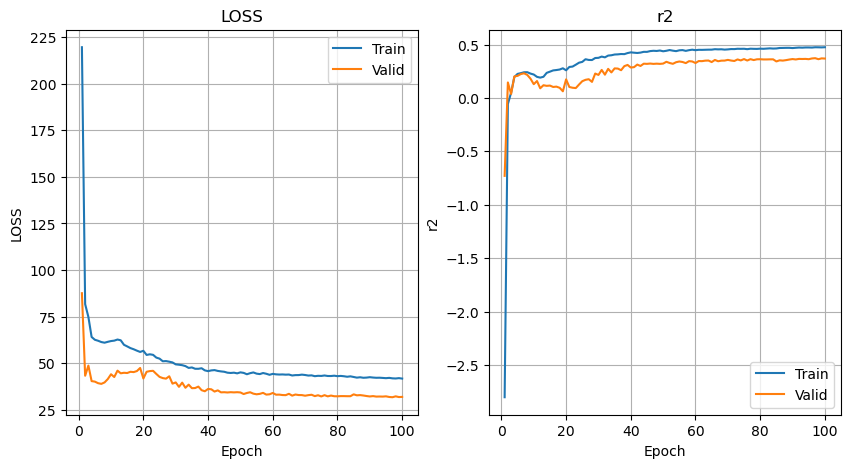

In [14]:
import matplotlib.pyplot as plt

THRESHOLD = 100

fig, axes = plt.subplots(1,2, figsize=(10,5))

axes[0].plot(range(1, THRESHOLD+1), loss[0][:THRESHOLD],label="Train")
axes[0].plot(range(1, THRESHOLD+1), loss[1][:THRESHOLD],label="Valid")
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("LOSS")
axes[0].set_title("LOSS")

axes[1].plot(range(1, THRESHOLD+1), r2[0][:THRESHOLD],label="Train")
axes[1].plot(range(1, THRESHOLD+1), r2[1][:THRESHOLD],label="Valid")
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("r2")
axes[1].set_title("r2")
